# Optimization: principles and algorithms

Bierlaire, M. (2015). *Optimization: Principles and Algorithms.* EPFL Press.<br>
The numbering of the algorithms, tables and page refer to the book.

## Chapter 12: Trust region

### Algorithm 12.1: Intersection with the trust region

In [1]:
import numpy as np
from scipy import linalg

# Define a function simple to call for the inner product
def scalarInner(a,b):
    return(np.asscalar(a.T.dot(b)))

# Trust region of radius delta, centered at xhat
# xc in in the trust region. 
# Define dc = xc - xhat. We have ||dc|| <= delta
# Consider xd outside of the trust region. 
# Define dd = xd - xhat. We have ||dd|| > delta
# Find lbd such that || dc + lbd (dd - dc)|| = delta
def trustRegionIntersection(dc,d,delta):
    a = scalarInner(d,d)
    b = 2 * scalarInner(dc,d)
    c = scalarInner(dc,dc) - delta ** 2
    discriminant = b * b - 4.0 * a * c
    return (- b + np.sqrt(discriminant) ) / (2 * a)
    

The following example is not in the book.

In [6]:
xhat = np.array([[1],[1]])
delta = 1.0
xc = np.array([[1],[1.5]])
xd = np.array([[2.5],[5]])
dc = xc - xhat
dd = xd - xhat
lbd = trustRegionIntersection(dc,dd-dc,delta)
lbd

0.13677904350117376

We verify that $||d_C + \lambda (d_d - d_C)|| = \Delta$.

In [3]:
linalg.norm(dc + lbd *(dd - dc))

0.9999999999999999

The point on the border is $x_C + \lambda (x_d - x_C)$.

In [4]:
xborder = xc + lbd * (xd - xc)
xborder

array([[1.20516857],
       [1.97872665]])

The following figure illustrates the various points involved.

NameError: name 'xborder' is not defined

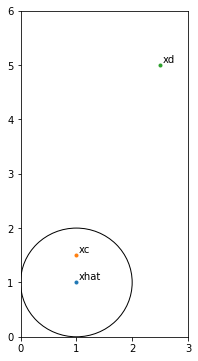

In [7]:
def myplot(ax,x,name,shift=0.05):
    ax.plot(x.item(0),x.item(1),marker='.')
    ax.annotate(name,xy=(x.item(0),x.item(1)),xytext=(x.item(0)+shift,x.item(1)+shift))
   
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [3,6]
circle = plt.Circle((1,1),1.0,fill=False)
ax = plt.gca()
ax.set_xlim((0, 3))
ax.set_ylim((0, 6))
ax.add_artist(circle)
shift=0.05

myplot(ax,xhat,'xhat')
myplot(ax,xc,'xc')
myplot(ax,xd,'xd')
myplot(ax,xborder,'xborder')

# Plot the line
plt.plot([xc.item(0),xd.item(0)],[xc.item(1),xd.item(1)])

plt.show()

### Algorithm 12.2: Dogleg method

In [6]:
def cauchyNewtonDogleg(g,H):
    alpha = scalarInner(g,g)
    beta = scalarInner(g,H.dot(g))
    dc = - (alpha / beta ) * g  
    dn = linalg.solve(H,-g).reshape(2,1)
    eta = 0.2 + (0.8 * alpha * alpha / (beta * abs(scalarInner(g,dn)))) 
    return dc,dn,eta*dn
    
def dogleg(g,H,delta):
    """
    Returned type interpretation
    type -2: negative curvature along Newton's direction
    type -1: negative curvature along Cauchy's direction (i.e. along the gradient)
    type  1: Partial Cauchy step 
    type  2: Newton step
    type  3: Partial Newton step
    type  4: Dogleg
    """

    (dc,dn,dl) = cauchyNewtonDogleg(g,H)
    
    # Check if the model is convex along the gradient direction
    
    alpha = scalarInner(g,g)
    beta = scalarInner(g,H.dot(g))
    if beta <= 0:
        dstar = -delta * g / np.sqrt(alpha)
        return dstar,-1

    # Compute the Cauchy point
    
    normdc = alpha * np.sqrt(alpha) / beta ;
    if normdc >= delta:
        # The Cauchy point is outside the trust
        # region. We move along the Cauchy
        # direction until the border of the trut
        # region.

        dstar = (delta / normdc) * dc
        return dstar, 1

    # Compute Newton's point

    
    normdn = linalg.norm(dn)

    # Check the convexity of the model along Newton's direction

    if scalarInner(dn,H.dot(dn)) <= 0.0:
        # Return the Cauchy point
        return dc,-2


    if normdn <= delta: 
        # Newton's point is inside the trust region
        return dn,2


    # Compute the dogleg point

    eta = 0.2 + (0.8 * alpha * alpha / (beta * abs(scalarInner(g,dn))))  

    partieldn = eta * linalg.norm(dn)
    
    if partieldn <= delta:
        # Dogleg point is inside the trust region
        dstar = (delta / normdn) * dn ;
        return dstar,3
  
    # Between Cauchy and dogleg
    nu = dl - dc
    lbd = trustRegionIntersection(dc,nu,delta)  
    dstar = dc + lbd * nu ;
    return dstar,4

Example 12.3 p. 295

In [7]:
xhat = np.array([[9],[1]])
g = np.array([[9],[9]])
H = np.array([[1., 0],
       [0, 9.]])
delta = 1
(dstar1,type1) = dogleg(g,H,delta)
x1 = xhat + dstar1
print("Delta: {} Type: {}\nx={}".format(delta,type1,x1))
delta = 4
(dstar4,type4) = dogleg(g,H,delta)
x4 = xhat + dstar4
print("Delta: {} Type: {}\nx={}".format(delta,type4,x4))
delta = 8
(dstar8,type8) = dogleg(g,H,delta)
x8 = xhat + dstar8
print("Delta: {} Type: {}\nx={}".format(delta,type8,x8))

Delta: 1 Type: 1
x=[[8.29289322]
 [0.29289322]]
Delta: 4 Type: 4
x=[[5.06523072]
 [0.28056223]]
Delta: 8 Type: 3
x=[[1.04893012]
 [0.11654779]]


Figure 12.2 (a) p. 296

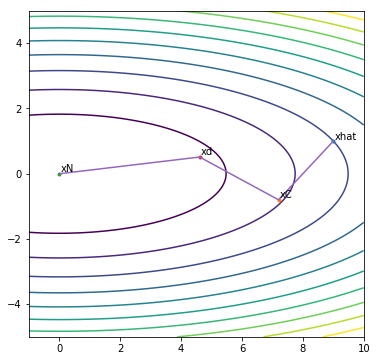

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [6,6]

def theFunctionToPlot(x,y):
    return(0.5 * x * x + 4.5 * y * y)

xlist = np.linspace(-1.0,10.0,1000)
ylist = np.linspace(-5.0,5.0,1000)
X,Y = np.meshgrid(xlist,ylist)
Z = theFunctionToPlot(X,Y)
plt.contour(X,Y,Z,15)

ax = plt.gca()
ax.set_xlim((-1, 10))
ax.set_ylim((-5, 5))
(dc,dn,dl) = cauchyNewtonDogleg(g,H)
myplot(ax,xhat,'xhat')
xc = xhat + dc
myplot(ax,xc,'xC')
xn = xhat + dn
myplot(ax,xn,'xN')
xd = xhat + dl 
myplot(ax,xhat+dl,'xd')
x_points = [xhat.item(0),xc.item(0),xd.item(0),xn.item(0)]
y_points = [xhat.item(1),xc.item(1),xd.item(1),xn.item(1)]
plt.plot(x_points,y_points)
plt.show()

Figure 12.2 (b) p. 296

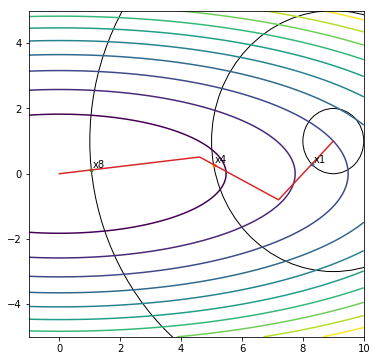

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [6,6]

def theFunctionToPlot(x,y):
    return(0.5 * x * x + 4.5 * y * y)

xlist = np.linspace(-1.0,10.0,1000)
ylist = np.linspace(-5.0,5.0,1000)
X,Y = np.meshgrid(xlist,ylist)
Z = theFunctionToPlot(X,Y)
plt.contour(X,Y,Z,15)


circle1 = plt.Circle((9,1),1.0,fill=False)
circle4 = plt.Circle((9,1),4.0,fill=False)
circle8 = plt.Circle((9,1),8.0,fill=False)
ax = plt.gca()
ax.set_xlim((-1, 10))
ax.set_ylim((-5, 5))
ax.add_artist(circle1)
ax.add_artist(circle4)
ax.add_artist(circle8)
myplot(ax,x1,'x1')
myplot(ax,x4,'x4')
myplot(ax,x8,'x8')
x_points = [xhat.item(0),xc.item(0),xd.item(0),xn.item(0)]
y_points = [xhat.item(1),xc.item(1),xd.item(1),xn.item(1)]
plt.plot(x_points,y_points)
plt.show()

### Algorithm 12.3: Steihaug-Toint truncated conjugate gradient method

In [10]:
def truncatedConjugateGradient(g,H,delta):
    """
    Returned type interpretation
    type  1: convergence
    type  2: out of the trust region
    type  3: negative curvature detected
    """
    tol = 1.0e-6
    n = g.shape[0]
    xk = np.zeros((n,1))
    gk = g 
    dk = -gk
    for k in range(n):
        curv = scalarInner(dk,H.dot(dk))
        if  curv <= 0:
            # Negative curvature has been detected
            type = 3
            a = scalarInner(dk,dk) 
            b = 2 * scalarInner(xk,dk)
            c = scalarInner(xk,xk) - delta * delta
            rho = b * b - 4 * a * c ;
            step = xk + ((-b + np.sqrt(rho)) / (2*a)) * dk
            return step,type
        alphak = - scalarInner(dk,gk) / curv
        xkp1 = xk + alphak * dk
        if linalg.norm(xkp1) > delta:
            # Out of the trust region
            type = 2 
            a = scalarInner(dk,dk) 
            b = 2 * scalarInner(xk,dk)
            c = scalarInner(xk,xk) - delta * delta
            rho = b * b - 4 * a * c ;
            step = xk + ((-b + np.sqrt(rho)) / (2*a)) * dk
            return step, type
        xk = xkp1 ;
        gkp1 = H.dot(xk) + g
        betak = scalarInner(gkp1,gkp1) / scalarInner(gk,gk)
        dk = -gkp1 + betak * dk
        gk = gkp1
        if linalg.norm(gkp1) <= tol:
          type = 1
          step = xk
          return step,type
    type = 1
    step = xk
    return step, type

We illustrate the method on the same example as before. This is not reported in the book. Note that there is no negative curvature here. Also, we have a large trust region ($\Delta=10$) to illustrate the case when the CG algorithm converges without hitting the trust region boundaries.

In [11]:
xhat = np.array([[9],[1]])
g = np.array([[9],[9]])
H = np.array([[1., 0],
       [0, 9.]])
delta = 1
(step1,type1) = truncatedConjugateGradient(g,H,delta)
x1 = xhat + step1
print("Delta: {} Type: {}\nx={}".format(delta,type1,x1))
delta = 4
(step4,type4) = truncatedConjugateGradient(g,H,delta)
x4 = xhat + step4
print("Delta: {} Type: {}\nx={}".format(delta,type4,x4))
delta = 8
(step8,type8) = truncatedConjugateGradient(g,H,delta)
x8 = xhat + step8
print("Delta: {} Type: {}\nx={}".format(delta,type8,x8))
delta = 10
(step10,type10) = truncatedConjugateGradient(g,H,delta)
x10 = xhat + step10
print("Delta: {} Type: {}\nx={}".format(delta,type10,x10))

Delta: 1 Type: 2
x=[[8.29289322]
 [0.29289322]]
Delta: 4 Type: 2
x=[[ 5.33058286]
 [-0.59228698]]
Delta: 8 Type: 2
x=[[ 1.07876863]
 [-0.11986318]]
Delta: 10 Type: 1
x=[[0.00000000e+00]
 [2.22044605e-16]]


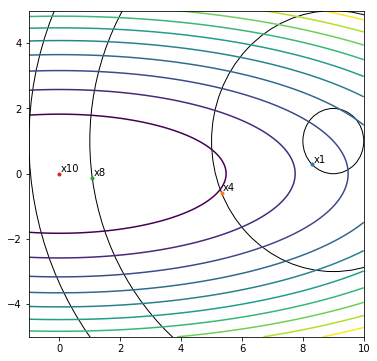

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [6,6]

def theFunctionToPlot(x,y):
    return(0.5 * x * x + 4.5 * y * y)

xlist = np.linspace(-1.0,10.0,1000)
ylist = np.linspace(-5.0,5.0,1000)
X,Y = np.meshgrid(xlist,ylist)
Z = theFunctionToPlot(X,Y)
plt.contour(X,Y,Z,15)


circle1 = plt.Circle((9,1),1.0,fill=False)
circle4 = plt.Circle((9,1),4.0,fill=False)
circle8 = plt.Circle((9,1),8.0,fill=False)
circle10 = plt.Circle((9,1),10.0,fill=False)
ax = plt.gca()
ax.set_xlim((-1, 10))
ax.set_ylim((-5, 5))
ax.add_artist(circle1)
ax.add_artist(circle4)
ax.add_artist(circle8)
ax.add_artist(circle10)
myplot(ax,x1,'x1')
myplot(ax,x4,'x4')
myplot(ax,x8,'x8')
myplot(ax,x10,'x10')
plt.show()

### Algorithm 12.4: Newton's method with trust region

In [13]:
def newtonTrustRegion(obj,x0,delta0=10,eps=1.0e-6,dl=True,maxiter=1000):
    
    eta1 = 0.01
    eta2 = 0.9
    k = 0
    xk = x0
    (f,g,H) = obj(xk)
    iters = list()
    delta = delta0 ;
    iters.append([xk,f,linalg.norm(g),delta,0.0,'',''])
    while linalg.norm(g) > eps and k < maxiter:
        k=k+1
        if dl:
            (step,type) = dogleg(g,H,delta)
        else: 
            (step,type) = truncatedConjugateGradient(g,H,delta)
        (fc,gc,Hc) = obj(xk+step)
        num = f - fc;
        denom = -scalarInner(step,g) - 0.5 * scalarInner(step,H.dot(step))
        rho = num / denom
        if rho < eta1:
            # Failure: reduce the trust region
            delta = linalg.norm(step) / 2.0
            status = "- " ;
        else:
            # Candidate accepted
            xk = xk + step
            f = fc
            g = gc
            H = Hc
            if rho >= eta2:
                # Enlarge the trust region
                delta = 2 * delta
                status = "++"
            else:
                status = "+ "
        iters.append([xk,f,linalg.norm(g),delta,rho,type,status])
    return xk,iters

Example 5.8: $f(x_1,x_2) = \frac{1}{2} x_1^2 + x_1 \cos(x_2)$

In [14]:
import math
def ex0508(x):
    f = 0.5 * x.item(0) * x.item(0) + x.item(0) * math.cos(x.item(1))
    g = np.array([[ x.item(0) + math.cos(x.item(1))],[ -x.item(0) * math.sin(x.item(1)) ] ])
    H = np.array([[ 1 , -math.sin(x.item(1))],[ -math.sin(x.item(1)),-x.item(0)*math.cos(x.item(1))]])
    return (f,g,H)
                                                      

In [15]:
x0 = np.array([[1],[1]])
(sol,iters) = newtonTrustRegion(ex0508,x0)
sol

array([[-1.00000025e+00],
       [-5.40690858e-07]])

Table 12.1, page 304

In [16]:
print("k\txk\t\t\t\tf(xk)\t\t||Grad(xk)||\tDeltak\t\tRho\t\tStatus")
for k in range(len(iters)):
    print("{}\t{:+E}\t{:+E}\t{:+E}\t{:+E}\t{:+E}\t{:+E}\t{}\t{}".format(k,iters[k][0].item(0),iters[k][0].item(1),iters[k][1],iters[k][2],iters[k][3],iters[k][4],iters[k][5],iters[k][6]))


k	xk				f(xk)		||Grad(xk)||	Deltak		Rho		Status
0	+1.000000E+00	+1.000000E+00	+1.040302E+00	+1.755165E+00	+1.000000E+01	+0.000000E+00		
1	-2.338451E-01	+1.364192E+00	-2.062862E-02	+2.306654E-01	+2.000000E+01	+9.614446E-01	2	++
2	-1.395487E-01	+6.124147E-01	-1.044505E-01	+6.834378E-01	+4.000000E+01	+9.592373E-01	-2	++
3	-9.344969E-01	+5.184577E-01	-3.750473E-01	+4.677489E-01	+8.000000E+01	+9.892413E-01	-2	++
4	-1.245337E+00	-2.418279E-01	-4.336678E-01	+4.052853E-01	+8.000000E+01	+3.535767E-01	2	+ 
5	-1.019246E+00	-3.995314E-02	-4.990014E-01	+4.537823E-02	+1.600000E+02	+1.068830E+00	2	++
6	-1.000770E+00	-7.033741E-04	-4.999995E-01	+1.043234E-03	+3.200000E+02	+1.014141E+00	2	++
7	-1.000000E+00	-5.406909E-07	-5.000000E-01	+5.944321E-07	+6.400000E+02	+1.000350E+00	2	++


Figure 12.3 (a) p. 303

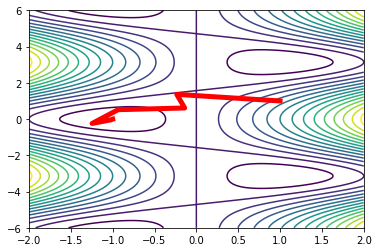

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
def theFunctionToPlot(x,y):
    return(0.5 * x * x + x * np.cos(y))

xlist = np.linspace(-2.0,2.0,1000)
ylist = np.linspace(-6.0,6.0,1000)
X,Y = np.meshgrid(xlist,ylist)
Z = theFunctionToPlot(X,Y)
plt.contour(X,Y,Z,15)
xiter = [iters[k][0].item(0) for k in range(len(iters))]
yiter = [iters[k][0].item(1) for k in range(len(iters))]
plt.plot(xiter,yiter, linewidth=5, color='r')
plt.show()

Figure 12.3 (b)

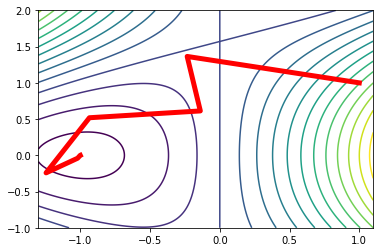

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
def theFunctionToPlot(x,y):
    return(0.5 * x * x + x * np.cos(y))

xlist = np.linspace(-1.3,1.1,1000)
ylist = np.linspace(-1,2,1000)
X,Y = np.meshgrid(xlist,ylist)
Z = theFunctionToPlot(X,Y)
plt.contour(X,Y,Z,15)
xiter = [iters[k][0].item(0) for k in range(len(iters))]
yiter = [iters[k][0].item(1) for k in range(len(iters))]
plt.plot(xiter,yiter, linewidth=5, color='r')
plt.show()

In [19]:
x0 = np.array([[1],[1]])
(sol,iters) = newtonTrustRegion(ex0508,x0,delta0=1)
sol

array([[-1.00000000e+00],
       [ 7.23075033e-12]])

Table 12.2, page 305

In [20]:
print("k\txk\t\t\t\tf(xk)\t\t||Grad(xk)||\tDeltak\t\tRho\t\tStatus")
for k in range(len(iters)):
    print("{}\t{:+E}\t{:+E}\t{:+E}\t{:+E}\t{:+E}\t{:+E}\t{}\t{}".format(k,iters[k][0].item(0),iters[k][0].item(1),iters[k][1],iters[k][2],iters[k][3],iters[k][4],iters[k][5],iters[k][6]))


k	xk				f(xk)		||Grad(xk)||	Deltak		Rho		Status
0	+1.000000E+00	+1.000000E+00	+1.040302E+00	+1.755165E+00	+1.000000E+00	+0.000000E+00		
1	+1.224174E-01	+1.479426E+00	+1.866284E-02	+2.459926E-01	+2.000000E+00	+9.475885E-01	1	++
2	-1.016285E-03	+1.570031E+00	-2.614639E-07	+1.046790E-03	+4.000000E+00	+9.975358E-01	2	++
3	-5.364085E-04	+1.568087E+00	-1.309492E-06	+2.238245E-03	+8.000000E+00	+1.000000E+00	-2	++
4	-5.089851E-03	+1.566963E+00	-6.558303E-06	+5.242594E-03	+1.600000E+01	+9.999983E-01	-2	++
5	-2.686573E-03	+1.557227E+00	-3.284477E-05	+1.120891E-02	+3.200000E+01	+1.000001E+00	-2	++
6	-2.548821E-02	+1.551598E+00	-1.644658E-04	+2.624866E-02	+6.400000E+01	+9.999570E-01	-2	++
7	-1.346383E-02	+1.502894E+00	-8.228867E-04	+5.602070E-02	+1.280000E+02	+1.000022E+00	-2	++
8	-1.272299E-01	+1.474795E+00	-4.101757E-03	+1.304729E-01	+2.560000E+02	+9.989287E-01	-2	++
9	-6.847501E-02	+1.237641E+00	-2.004875E-02	+2.665266E-01	+5.120000E+02	+1.000511E+00	-2	++
10	-5.884662E-01	+1.107498E+00	-8.9839

Figure 12.4 (a), page 307

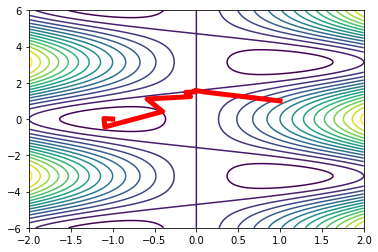

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
def theFunctionToPlot(x,y):
    return(0.5 * x * x + x * np.cos(y))

xlist = np.linspace(-2.0,2.0,1000)
ylist = np.linspace(-6.0,6.0,1000)
X,Y = np.meshgrid(xlist,ylist)
Z = theFunctionToPlot(X,Y)
plt.contour(X,Y,Z,15)
xiter = [iters[k][0].item(0) for k in range(len(iters))]
yiter = [iters[k][0].item(1) for k in range(len(iters))]
plt.plot(xiter,yiter, linewidth=5, color='r')
plt.show()

Figure 12.4 (b) page 307

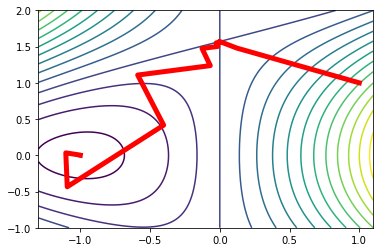

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
def theFunctionToPlot(x,y):
    return(0.5 * x * x + x * np.cos(y))

xlist = np.linspace(-1.3,1.1,1000)
ylist = np.linspace(-1,2,1000)
X,Y = np.meshgrid(xlist,ylist)
Z = theFunctionToPlot(X,Y)
plt.contour(X,Y,Z,15)
xiter = [iters[k][0].item(0) for k in range(len(iters))]
yiter = [iters[k][0].item(1) for k in range(len(iters))]
plt.plot(xiter,yiter, linewidth=5, color='r')
plt.show()

In [23]:
x0 = np.array([[1],[1]])
(sol,iters) = newtonTrustRegion(ex0508,x0,dl=False)
sol

array([[0.99999957],
       [3.14159243]])

Table 12.3, page 306

In [24]:
print("k\txk\t\t\t\tf(xk)\t\t||Grad(xk)||\tDeltak\t\tRho\t\tStatus")
for k in range(len(iters)):
    print("{}\t{:+E}\t{:+E}\t{:+E}\t{:+E}\t{:+E}\t{:+E}\t{}\t{}".format(k,iters[k][0].item(0),iters[k][0].item(1),iters[k][1],iters[k][2],iters[k][3],iters[k][4],iters[k][5],iters[k][6]))


k	xk				f(xk)		||Grad(xk)||	Deltak		Rho		Status
0	+1.000000E+00	+1.000000E+00	+1.040302E+00	+1.755165E+00	+1.000000E+01	+0.000000E+00		
1	+1.000000E+00	+1.000000E+00	+1.040302E+00	+1.755165E+00	+5.000000E+00	-7.519745E-02	3	- 
2	+1.000000E+00	+1.000000E+00	+1.040302E+00	+1.755165E+00	+2.500000E+00	-1.239910E-01	3	- 
3	+5.502300E-01	+3.459209E+00	-3.713324E-01	+4.351213E-01	+2.500000E+00	+4.196236E-01	3	+ 
4	+1.167903E+00	+2.761422E+00	-4.025175E-01	+4.950629E-01	+2.500000E+00	+1.700281E-01	1	+ 
5	+1.063652E+00	+3.125362E+00	-4.978341E-01	+6.607830E-02	+5.000000E+00	+1.043574E+00	1	++
6	+1.000116E+00	+3.140624E+00	-4.999995E-01	+9.752760E-04	+1.000000E+01	+1.003425E+00	1	++
7	+9.999996E-01	+3.141592E+00	-5.000000E-01	+4.819965E-07	+2.000000E+01	+1.000114E+00	1	++


Figure 12.5 (a), page 307

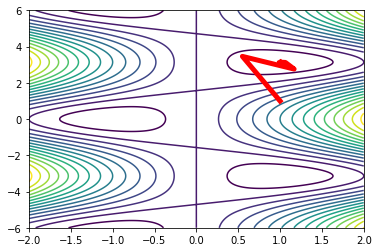

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
def theFunctionToPlot(x,y):
    return(0.5 * x * x + x * np.cos(y))

xlist = np.linspace(-2.0,2.0,1000)
ylist = np.linspace(-6.0,6.0,1000)
X,Y = np.meshgrid(xlist,ylist)
Z = theFunctionToPlot(X,Y)
plt.contour(X,Y,Z,15)
xiter = [iters[k][0].item(0) for k in range(len(iters))]
yiter = [iters[k][0].item(1) for k in range(len(iters))]
plt.plot(xiter,yiter, linewidth=5, color='r')
plt.show()

Figure 12.5 (b), page 307

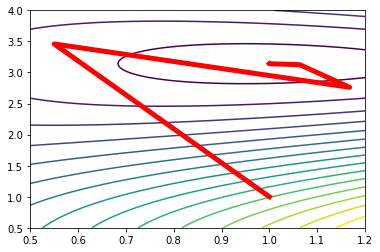

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
def theFunctionToPlot(x,y):
    return(0.5 * x * x + x * np.cos(y))

xlist = np.linspace(0.5,1.2,1000)
ylist = np.linspace(0.5,4,1000)
X,Y = np.meshgrid(xlist,ylist)
Z = theFunctionToPlot(X,Y)
plt.contour(X,Y,Z,15)
xiter = [iters[k][0].item(0) for k in range(len(iters))]
yiter = [iters[k][0].item(1) for k in range(len(iters))]
plt.plot(xiter,yiter, linewidth=5, color='r')
plt.show()

### Section 12.3 The Rosenbrock problem

In [27]:
from optimizationExamples import *
def exRosenbrockWithHessian(x):
    return exRosenbrock(x,True)
x0 = np.array([[-1.5],[1.5]])
ex0 = np.array([[1],[1]])
(sol,iters) = newtonTrustRegion(exRosenbrockWithHessian,x0)
sol

array([[1.],
       [1.]])

Figure 12.6 (a), page 308

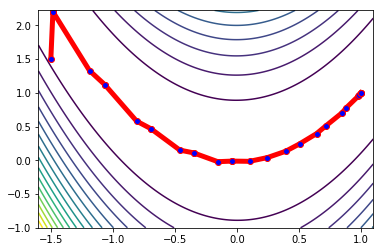

In [28]:
def theFunctionToPlot(x,y):
    return(100 * (y-x*x)**2+(1-x)**2)

xlist = np.linspace(-1.6,1.1,1000)
ylist = np.linspace(-1,2.22,1000)
X,Y = np.meshgrid(xlist,ylist)
Z = theFunctionToPlot(X,Y)
plt.contour(X,Y,Z,20)
xiter = [iters[k][0].item(0) for k in range(len(iters))]
yiter = [iters[k][0].item(1) for k in range(len(iters))]
plt.plot(xiter,yiter, linewidth=5, color='r',marker='o',mfc='blue')
plt.show()

Figure 12.6 (b), page 308

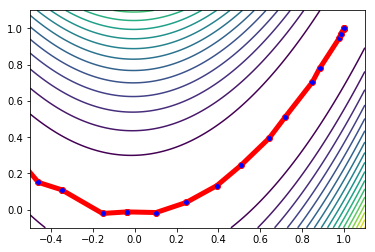

In [29]:
def theFunctionToPlot(x,y):
    return(100 * (y-x*x)**2+(1-x)**2)

xmin = -0.5
xmax = 1.1
ymin = -0.1
ymax = 1.1
xlist = np.linspace(xmin,xmax,1000)
ylist = np.linspace(ymin,ymax,1000)
X,Y = np.meshgrid(xlist,ylist)
Z = theFunctionToPlot(X,Y)
plt.contour(X,Y,Z,20)
xiter = [iters[k][0].item(0) for k in range(len(iters))]
yiter = [iters[k][0].item(1) for k in range(len(iters))]
plt.xlim([xmin,xmax])
plt.ylim([ymin,ymax])
plt.plot(xiter,yiter, linewidth=5, color='r',marker='o',mfc='blue')
plt.show()